In [ ]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless" wandb

In [ ]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()

Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


Notebook Color Schemes:


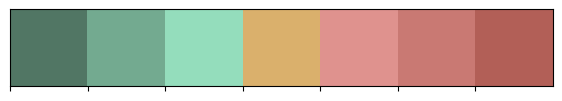

In [ ]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C",
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [ ]:
train_row_data = pd.read_csv("train_dicom_row_data.csv")
train = pd.read_csv("train.csv")
train_df = pd.merge(train_row_data, train, left_on="PatientID", right_on="patient_id", how="inner")

# patient_id 열 삭제
train_df.drop(columns=["patient_id"], inplace=True)

In [ ]:
print(train_df.columns)
train_df

Index(['PatientID', 'HighBit', 'PatientPosition', 'RescaleType',
       'SeriesNumber', 'aortic_hu', 'ImageOrientationPatient1',
       'ImageOrientationPatient2', 'ImageOrientationPatient3',
       'ImageOrientationPatient4', 'ImageOrientationPatient5',
       'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2',
       'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury'],
      dtype='object')


,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,...,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,...,1,0,0,1,0,0,1,0,0,0
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,...,1,0,0,1,0,0,1,0,0,0
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,0
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,0,0,1
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,0,0,1


In [ ]:
train_df['bowel_healthy'].value_counts()

1    4607
0     104
Name: bowel_healthy, dtype: int64

**-------------원래코드-------------**

In [ ]:
!pip install -q efficientnet_pytorch
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
class RSNADataset(Dataset):

    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip

        # Data Augmentation (custom for each dataset type)
        if is_train:
            self.transform = Compose([RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        '''Take each row in batcj at a time.'''

        # Select path and read image
        image_path = self.dataframe['path'][index]
        image = pydicom.dcmread(image_path).pixel_array.astype(np.float32)

        # For this image also import .csv information
        csv_data = np.array(self.dataframe.iloc[index][csv_columns].values,
                            dtype=np.float32)
        # Apply transforms
        transf_image = self.transform(image=image)['image']
        # Change image from 1 channel (B&W) to 3 channels
        transf_image = np.concatenate([transf_image, transf_image, transf_image], axis=0)

        # Return info
        if self.is_train:
            return {"image": transf_image,
                    "meta": csv_data,
                    "target": self.dataframe['cancer'][index]}
        else:
            return {"image": transf_image,
                    "meta": csv_data}

def data_to_device(data):

    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

# Sample data
sample_df = train.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Meta:" + clr.E, meta, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size

        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))

        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)


    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)

        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)

        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)

        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)

        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)

        return out
# Load Model
model_example = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = model_example(image, meta, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float())
print("="*50)
print(clr.S+'Loss:'+clr.E, loss.item())


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# DataFrame df 로드 (가정: df는 이미지 경로, 레이블, 메타데이터를 포함)
# 예: df = pd.read_csv('your_dataset.csv')

# 여기서는 예시를 위해 빈 DataFrame을 생성합니다.
df = pd.DataFrame({
    'PatientID':[
        '10981',
        '122',
        '1250'
    ],
    'path': [
        'png_test_jjw/10981/53877/img_225x225_d1_original/image_001.png',
        'png_test_jjw/122/8218/img_225x225_d1_original/image_001.png',
        'png_test_jjw/1250/56073/img_225x225_d1_original/image_001.png'

    ],  # 이미지 경로
    'cancer': [
        1,
        0,
        1
    ],  # 레이블
    # ... 기타 메타데이터 컬럼
})

# 추가적인 CSV 파일 로드
additional_df = pd.read_csv('rsna_data/train_dicom_row_data.csv')

# 'path' 컬럼을 기준으로 기존의 df와 병합
df = pd.merge(df, additional_df, on='PatientID', how='left')

# CSV 컬럼 업데이트
csv_columns = df.columns.drop(['path', 'cancer'])
# csv_columns = df.columns.drop(['path', 'cancer'])
vertical_flip = 0.5  # 예시 값
horizontal_flip = 0.5  # 예시 값
output_size = 1  # 예시 값: 이진 분류 문제
no_columns = len(csv_columns)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = A.Compose([
                A.RandomResizedCrop(height=256, width=256),
                A.ShiftScaleRotate(rotate_limit=90, scale_limit=[0.8, 1.2]),
                A.HorizontalFlip(p=self.horizontal_flip),
                A.VerticalFlip(p=self.vertical_flip),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['path'][index]
        image = np.array(Image.open(image_path).convert('L'), dtype=np.float32)
        csv_data = np.array(self.dataframe.loc[index, csv_columns].values, dtype=np.float32)
        transf_image = self.transform(image=image)['image']
        transf_image = np.concatenate([transf_image, transf_image, transf_image], axis=0)
        if self.is_train:
            return {"image": transf_image, "meta": csv_data, "target": float(self.dataframe['cancer'][index])}
        else:
            return {"image": transf_image, "meta": csv_data}


class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(
            nn.Linear(self.no_columns, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta, prints=False):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

def visualize_weights(model):
    # 예시로 첫 번째 Conv2D 레이어의 가중치를 시각화
    conv1_weights = model.features.conv1.weight.data.cpu().numpy()
    fig, axs = plt.subplots(1, conv1_weights.shape[0], figsize=(20, 20))
    for i in range(conv1_weights.shape[0]):
        axs[i].imshow(conv1_weights[i, 0], cmap='gray')
    plt.show()

# 다시 학습 및 검증 데이터셋 준비
train_df = df.sample(frac=0.8, random_state=42)
valid_df = df.drop(train_df.index)

train_dataset = RSNADataset(train_df, vertical_flip, horizontal_flip, is_train=True)
valid_dataset = RSNADataset(valid_df, vertical_flip, horizontal_flip, is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 모델 초기화 및 학습 설정
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        images = batch['image'].to(DEVICE)
        meta = batch['meta'].to(DEVICE)
        targets = batch['target'].to(DEVICE).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # 각 에포크마다 가중치 시각화
    visualize_weights(model)


In [ ]:
import matplotlib.pyplot as plt

# 예측 및 결과 표시
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        images = batch['image'].to(DEVICE)
        meta = batch['meta'].to(DEVICE)
        targets = batch['target'].to(DEVICE).unsqueeze(1).float()

        # 예측 수행
        outputs = model(images, meta)
        predictions = torch.sigmoid(outputs) > 0.5  # 예: 0.5의 임계값을 사용한 이진 분류

        # 결과와 이미지 표시
        for j in range(images.size(0)):
            image = images[j].cpu().numpy().transpose((1, 2, 0))
            target = targets[j].item()
            prediction = predictions[j].item()

            plt.imshow(image, cmap='gray')
            plt.title(f'Target: {target}, Prediction: {prediction}')
            plt.show()

            # 결과를 파일로 저장
            # plt.savefig(f'result_{i * valid_dataloader.batch_size + j}.png')


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
import pydicom
import numpy as np

# CSV 파일 로드
csv_file_path = 'rsna_data/train_dicom_row_data.csv'
csv_df = pd.read_csv(csv_file_path)

# 이미지 파일 경로 추가
image_paths = [
    'png_test_jjw/10981/53877/img_225x225_d1_original/image_001.png',
    'png_test_jjw/122/8218/img_225x225_d1_original/image_001.png',
    'png_test_jjw/1250/56073/img_225x225_d1_original/image_001.png'
]

selected_patient_ids = [10981, 122, 1250]
selected_df = csv_df[csv_df['PatientID'].isin(selected_patient_ids)]
# 필요한 csv_columns 선택

test_df = pd.DataFrame({
    'path': image_paths,
    'cancer': [0, 1, 0],  # 임의의 타겟값, 실제 값을 사용해야 함
    # 필요한 다른 컬럼들도 여기에 추가
})

# 필요한 csv_columns 선택
csv_columns = csv_df.columns.tolist()  # 필요한 컬럼 이름 리스트

# 테스트 데이터셋 생성
test_dataset = RSNADataset(test_df, vertical_flip=0.5, horizontal_flip=0.5, is_train=False)

# 테스트 DataLoader 생성
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)


In [ ]:
csv_df

**-----------------------수정중인 코드--------------------------**

In [ ]:
a = pd.read_csv("train_dicom_row_data.csv")
b = pd.read_csv("train.csv")
b = b[['patient_id','any_injury']]

In [ ]:
# a의 'PatientID'와 b의 'patient_id'를 기준으로 조인
merged_df = pd.merge(a, b, left_on='PatientID', right_on='patient_id', how='inner')
merged_df.drop(columns=["patient_id"], inplace=True)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,any_injury
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,1
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,1


In [ ]:
# dcm path 추가
path = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)
merged_df['path'] = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,any_injury,path
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0,train_images/49954/41479
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0,train_images/50737/59269
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/29738
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/5363
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0,train_images/51078/62342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/7720
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/60494
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,1,train_images/9549/36394
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,1,train_images/9549/20222


In [ ]:
merged_df['any_injury'].value_counts()

0    3423
1    1288
Name: any_injury, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, Normalize, ToFloat)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=256, width=256),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        combined_image = np.stack([image1, image2, image3], axis=-1)

        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)

        transf_image = self.transform(image=combined_image)['image']
        if self.is_train:
            return {"image": transf_image, "meta": csv_data, "target": row['any_injury']}
        else:
            return {"image": transf_image, "meta": csv_data}

# 모델 클래스 정의
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

In [ ]:
vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 1

selected_df = merged_df.iloc[:100]

# 테스트 데이터셋 및 DataLoader 생성
negative = selected_df[selected_df['any_injury'] == 0]
positive = selected_df[selected_df['any_injury'] == 1]

num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=1234)
positive_samples = positive.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([negative_samples, positive_samples], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['any_injury'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=True)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False, num_workers=2)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image, meta)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

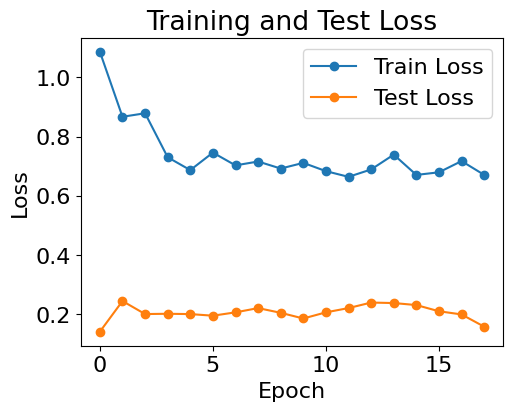

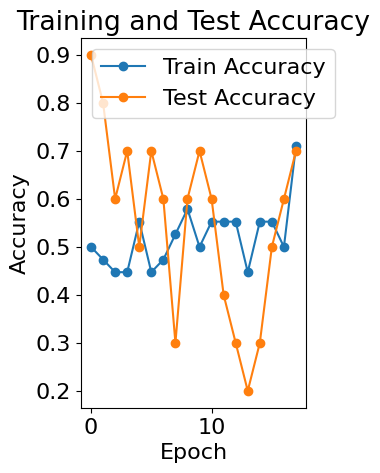

In [ ]:
# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses[2:], '-o', label='Train Loss')
plt.plot(test_losses[2:], '-o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[2:], '-o', label='Train Accuracy')
plt.plot(test_accuracies[2:], '-o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()